In [1]:
import imageio
import os
import random
import cv2

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from keras.models import load_model
from glob import glob
from skimage.transform import resize

In [1]:
import tensorflow as tf
print(f"TF Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(tf.test.is_built_with_cuda())

TF Version: 2.9.1
GPU Available: True
True


# Helper function

In [4]:
# mask 
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [5]:
def calculate_map(input_image, saved_model):


    test_image = np.expand_dims(input_image, axis=0)
    show_test_image = np.squeeze(test_image)

    decoded_img = saved_model.predict(test_image)
    show_decoded_image = np.squeeze(decoded_img)


    return show_decoded_image

In [6]:
'''
crop the image to satisfy the size of model
crop size = 300 * 300
'''


def crop_fish_eye(image_path):
    
    with Image.open(image_path) as img:
        h,w = img.size
        
        # get mask 
        image_mask = create_circular_mask(w,h,radius=150)
        
        # apply mask to img
        mask = np.stack([image_mask] * 3, axis=-1)
        masked_img = Image.fromarray(img * mask) # change nunmpy array to Image type 
        
        # 300 * 300 crop box centered at central
        crop_box = (h/2 - 150, w/2 -150, h/2 + 150, w/2 + 150) 
        
        cropped_img = masked_img.crop(crop_box)
    return cropped_img

# Model Comparision 

## CloudSegNet

In [7]:
# Segnet
SegNet_Night_Path = "I:\\Cloud segment models\\\CloudSegNet-night-ver\\results\\balanced_random_sample"
SegNet_Night = load_model(SegNet_Night_Path + '\\cloudsegnet.hdf5')

gt_output_file_path = "I:\\Cloud segment models\\Performance\\performance_on_testing_data/CloudSegNet"

In [8]:
SegNet_Night

In [9]:
testing_filepath = "I:\\Cloud segment models\\ACLNet_modify\\data"

testing_img = testing_filepath + "/imgs"

for f in os.listdir(testing_img):
    image_location = testing_img + "/" + f
    
    filename, suffix = f.split(".")
    print(filename,suffix)
    save_name = filename+"_GT"
    
    scene_image = cv2.imread(image_location)
    resized_image = resize(scene_image, (300, 300), order = 0) * 255
    resized_image = resized_image.astype("int")
    threshold = 0.8
    
    img_map = calculate_map(resized_image,SegNet_Night)
    
    result = np.zeros(img_map.shape)
    result[img_map > threshold] = 255
    result = Image.fromarray(result.astype("uint8"), 'L')
    
    result.save(gt_output_file_path + "/" + save_name + "." + suffix,format="PNG")


0816_day_aug png
1/1 [==============================] - 0s 151ms/step
0883_day png
1/1 [==============================] - 0s 26ms/step
093_night jpg
1/1 [==============================] - 0s 27ms/step
0674_day_aug png
1/1 [==============================] - 0s 29ms/step
0662_day png
1/1 [==============================] - 0s 21ms/step
0855_day_aug png
1/1 [==============================] - 0s 22ms/step
0403_day png
1/1 [==============================] - 0s 23ms/step
0499_day png
1/1 [==============================] - 0s 21ms/step
0562_day png
1/1 [==============================] - 0s 23ms/step
0050_day_aug png
1/1 [==============================] - 0s 30ms/step
0282_day_aug png
1/1 [==============================] - 0s 23ms/step
0530_day png
1/1 [==============================] - 0s 22ms/step
0156_day_aug png
1/1 [==============================] - 0s 22ms/step
0159_day png
1/1 [==============================] - 0s 20ms/step
0681_day_aug png
1/1 [==============================] - 0s 23ms/

## Unet

In [4]:
# Unet
import os
os.chdir("I:\\Cloud segment models\\Pytorch-UNet-night-ver")


import torch
import cv2

from unet import UNet
from predict import predict_img

In [5]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet import UNet
from utils.utils import plot_img_and_mask
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold 

    return mask[0].long().squeeze().numpy(), torch.sigmoid(output)[0].squeeze().numpy()

In [6]:
net = UNet(n_channels=3, n_classes=1, bilinear=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


net.to(device=device)
state_dict = torch.load("I:\\Cloud segment models\\Pytorch-UNet-night-ver\\checkpoints\\Unet_aug_data/checkpoint_epoch10.pth"
                        , map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)
print(device)

cuda


In [8]:
from scipy.ndimage import median_filter

gt_output_file_path = "I:\\Cloud segment models\\Performance\\performance_on_testing_data/Unet"
testing_filepath = "I:\\Cloud segment models\\ACLNet_modify\\data"

testing_img = testing_filepath + "/imgs"

for f in os.listdir(testing_img):
    f_path = testing_img + "/"+f 
    
    filename, suffix = f.split(".")
    save_name = filename+"_GT"
    save_name_png = save_name + ".png"
    save_name_jpg = save_name + ".jpg"
    
    out_f = gt_output_file_path + "/" + save_name
    
    if save_name_png in os.listdir(gt_output_file_path):
        continue
    if save_name_jpg in os.listdir(gt_output_file_path):
        continue
    print(save_name)
    img = Image.open(f_path)
    image_np = np.array(img)

    # Apply the median filter
    filtered_image_np =cv2.medianBlur(image_np, ksize=5)  # Adjust size as needed
    
    # Convert the filtered NumPy array back to a PIL Image
    img = Image.fromarray(filtered_image_np)

    pred, prob = predict_img(net = net , 
                       full_img = img,
                      scale_factor = 1,
                      out_threshold = 0.6,
                      device = device)
    
    
    pred = Image.fromarray(np.array(pred*255,dtype = "int8"),"L")
     
    pred.save(gt_output_file_path + "/" + save_name+ "." + suffix,format="PNG")
 

# ACLNet

In [ ]:
import os 
os.chdir("I:\\Cloud segment models\\ACLNet")

import sys
sys.path.append("./src/models")

import tensorflow as tf
from loss import *

ACLNet_image = "I:\\Cloud segment models\\ACLNet\\data\\imgs"


WEIGHTS_DIR = "I:\\Cloud segment models\\ACLNet\\weights/ACLNet_Best.h5"    
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})

In [16]:
def KNNOutput(image):
        Z = image.reshape((-1,3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
        K = 2
        _, label, center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        result = res.reshape((image.shape))
        return result

In [ ]:
sys.path.append("./src/data/")

from dataloader import *

gt_output_file_path = "I:\\Cloud segment models\\Performance\\performance_on_testing_data/ACLNet"
testing_filepath = "I:\\Cloud segment models\\ACLNet_modify\\data"

testing_img = testing_filepath + "/imgs"

resize_size = (288, 288)

for f in os.listdir(testing_img):
    f_path = testing_img + "/"+f 
    
    filename, suffix = f.split(".")
    save_name = filename+"_GT"
    
    image = cv2.imread(f_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, resize_size)
    
    
    
    
    
    image_np = np.array(image)
    
    knn_img_150=KNNOutput(image_np)
   
    
    image_np = np.expand_dims(image_np,axis = 0)
    knn_img_150 = np.expand_dims(knn_img_150,axis = 0)
    img_150=(image_np,knn_img_150/255)
    
    seg_150 = model.predict(img_150)
    mask_150 = seg_150[0].argmax(-1)*255
    mask_150 = Image.fromarray(mask_150.astype("uint8"))
    
    
    
    # apply threshold and get binary maska/
    threshold = 0.6
    result = np.zeros(seg_150[0][:,:,1].shape)
    result[seg_150[0][:,:,1] > threshold] = 255
    result = Image.fromarray(result.astype("uint8"), 'L')
    
    save_path = gt_output_file_path + "/" + save_name+"." + suffix
    print(save_path)
    result.save(save_path,format="PNG")
    

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0816_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0883_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/093_night_GT.jpg
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0674_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0662_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0855_day_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0403_day_GT.png
1/1 [=========

1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0454_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0158_day_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0931_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0401_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0106_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0002_day_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0452_day_aug_GT.png
1/1 [==========

1/1 [==============================] - 0s 20ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0478_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0460_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0779_day_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/050_night_GT.jpg
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0783_day_aug_GT.png
1/1 [==============================] - 0s 20ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0993_day_aug_GT.png
1/1 [==============================] - 0s 20ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0525_day_GT.png
1/1 [=====

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0485_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0816_day_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0244_day_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0634_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/1001_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0199_day_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/043_night_aug_GT.jpg
1/1 [=

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0211_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0585_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0814_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0480_day_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0033_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0162_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0149_day_aug_GT.png
1/1 [======

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0937_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0491_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0432_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/016_night_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0702_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0841_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0096_day_GT.png
1/1 [=====

1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0114_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0411_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0406_day_aug_GT.png
1/1 [==============================] - 0s 40ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0640_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0036_day_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/099_night_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0051_day_GT.png
1/1 [=============

1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0899_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0778_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/054_night_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/103_night_GT.jpg
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0462_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0313_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0859_day_GT.png
1/1 [============

1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0103_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0039_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0589_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0638_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/018_night_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0994_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0785_day_aug_GT.png
1/1 [=

1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0010_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0732_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0427_day_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0850_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0119_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0227_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0454_day_aug_GT.png
1/1 [======

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0763_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0362_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0079_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0201_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0550_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0521_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0857_day_aug_GT.png
1/1 [======

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/074_night_aug_GT.jpg
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0393_day_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0205_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0707_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0535_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0443_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0096_day_aug_GT.png
1/1 [=====

1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0682_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0377_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0653_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0525_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0317_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0703_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0346_day_aug_GT.png
1/1 [==

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0450_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0590_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/1013_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0218_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0495_day_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0988_day_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0931_day_aug_GT.png
1/1 [==

1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/083_night_GT.jpg
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0539_day_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0453_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0739_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0385_day_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0349_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0301_day_aug_GT.png
1/1 [=============

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0378_day_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0085_day_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0181_day_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/097_night_aug_GT.jpg
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0817_day_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0320_day_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0304_day_GT.png
1/1 [=========

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0616_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0538_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0249_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0580_day_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0781_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0574_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0294_day_GT.png
1/1 [==========

1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/004_night_aug_GT.jpg
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/082_night_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0498_day_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0868_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/108_night_aug_GT.jpg
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0969_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0700_day_aug_GT.png
1/1 [===

1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0206_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0019_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0004_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0524_day_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0903_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0520_day_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0083_day_aug_GT.png
1/1 [==

1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0022_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0519_day_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0739_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0453_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0077_day_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0503_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/037_night_aug_GT.jpg
1/1 [=====

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0575_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/089_night_aug_GT.jpg
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0522_day_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0182_day_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0680_day_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0777_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0940_day_aug_GT.png
1/1 [=

1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/033_night_aug_GT.jpg
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0762_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0360_day_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0919_day_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/047_night_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0383_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0171_day_GT.png
1/1 [============

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0420_day_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0131_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0314_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0445_day_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0956_day_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0380_day_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0985_day_aug_GT.png
1/1 [======

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0417_day_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/112_night_GT.jpg
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0895_day_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0483_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0142_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0923_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0405_day_f_aug_GT.pn

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0693_day_f_aug_GT.png
1/1 [==============================] - 0s 45ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0360_day_f_aug_GT.png
1/1 [==============================] - 0s 38ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0729_day_f_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0369_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0604_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0178_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0927_da

1/1 [==============================] - 0s 40ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0015_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0477_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0963_day_f_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0316_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0266_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0342_day_f_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0012_da

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0007_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0841_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0348_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0934_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0254_day_f_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0848_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0918_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0197_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0433_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0212_day_f_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0851_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0754_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0624_day_f_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0132_da

1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0011_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0125_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0307_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0106_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0447_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0210_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0134_da

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0415_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0481_day_f_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0318_day_f_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0195_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0377_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0272_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0039_da

1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0983_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0547_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0374_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0283_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0744_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0037_day_f_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0384_da

1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/010_night_f_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/009_night_f_aug_GT.jpg
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/008_night_f_aug_GT.jpg
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/007_night_f_aug_GT.jpg
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/006_night_f_aug_GT.jpg
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/005_night_f_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0

1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0059_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0710_day_f_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0104_day_f_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0872_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0654_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0534_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0340_da

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0570_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0532_day_f_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0802_day_f_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0225_day_f_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0133_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0655_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0887_da

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0400_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0005_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0207_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0638_day_f_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0211_day_f_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0946_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0746_da

1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0296_day_f_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0289_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0286_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0417_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0883_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0662_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0403_da

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0683_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0987_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0824_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/1007_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0245_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0397_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0968_da

1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0370_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0031_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0749_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0998_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0695_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0107_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0471_da

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0167_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0656_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0938_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0442_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0913_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0736_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0796_da

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0518_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0815_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0219_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0139_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0540_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0269_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0325_da

1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0246_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0891_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0594_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0988_day_f_aug_GT.png
1/1 [==============================] - 0s 21ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0665_day_f_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0651_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0297_da

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0694_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0673_day_f_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0929_day_f_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0190_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0676_day_f_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0303_day_f_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0628_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0485_day_l_aug_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0045_day_l_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0957_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0004_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0440_day_l_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0653_day_l_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0522_da

1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0566_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0455_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0488_day_l_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0853_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0424_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0444_day_l_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0585_da

1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0589_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0302_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0598_day_l_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0209_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0329_day_l_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0617_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0309_da

1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0314_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0520_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0051_day_l_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0506_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0214_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0378_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0181_da

1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0241_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0976_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0389_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0835_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0435_day_l_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0109_day_l_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0823_da

1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0885_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0780_day_l_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0179_day_l_aug_GT.png
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0917_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0884_day_l_aug_GT.png
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0791_day_l_aug_GT.png
1/1 [==============================] - 0s 24ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0464_da

1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/104_night_l_aug_GT.jpg
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/103_night_l_aug_GT.jpg
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/102_night_l_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/101_night_l_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/100_night_l_aug_GT.jpg
1/1 [==============================] - 0s 23ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/099_night_l_aug_GT.jpg
1/1 [==============================] - 0s 22ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0

1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0126_day_l_aug_GT.png
1/1 [==============================] - 0s 40ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0831_day_l_aug_GT.png
1/1 [==============================] - 0s 35ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0260_day_l_aug_GT.png
1/1 [==============================] - 0s 38ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0065_day_l_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0671_day_l_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0406_day_l_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0850_da

1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0176_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0714_day_l_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0845_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0517_day_l_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0901_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0921_day_l_aug_GT.png
1/1 [==============================] - 0s 45ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0345_da

1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0294_day_l_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0470_day_l_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0839_day_l_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0960_day_l_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0321_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0829_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0256_da

1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0402_day_l_aug_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0146_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0185_day_l_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0298_day_l_aug_GT.png
1/1 [==============================] - 0s 45ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0772_day_l_aug_GT.png
1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0643_day_l_aug_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0679_da

1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0955_day_l_aug_GT.png
1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0627_day_l_aug_GT.png
1/1 [==============================] - 0s 38ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0282_day_l_aug_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0861_day_l_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0371_day_l_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0941_day_l_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0350_da

1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0478_day_l_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0525_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0356_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0556_day_l_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0487_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/1004_day_l_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0489_da

1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0278_day_l_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0825_day_l_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0343_day_l_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0150_day_l_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0877_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/1012_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0550_da

1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0920_day_l_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0768_day_l_aug_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0820_day_l_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0985_day_l_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0149_day_l_aug_GT.png
1/1 [==============================] - 0s 55ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0399_day_l_aug_GT.png
1/1 [==============================] - 0s 47ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0761_da

1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0072_day_l_aug_GT.png
1/1 [==============================] - 0s 36ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0527_day_l_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0757_day_l_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0215_day_l_aug_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0910_day_l_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0549_day_l_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0235_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0357_day_l_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0784_day_l_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0137_day_l_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0629_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0732_day_l_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0119_day_l_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0191_da

1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0715_day_l_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0738_day_l_aug_GT.png
1/1 [==============================] - 0s 44ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0908_day_l_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0652_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0888_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0085_day_l_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0860_da

1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0026_morning_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0027_morning_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0028_morning_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0029_morning_GT.png
1/1 [==============================] - 0s 36ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0030_morning_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0031_morning_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0032_morning_GT.png

1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0140_morning_GT.png
1/1 [==============================] - 0s 35ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0141_morning_GT.png
1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0142_morning_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0143_morning_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0144_morning_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0145_morning_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0146_morning_GT.png

1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0254_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0255_morning_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0256_morning_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0257_morning_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0258_morning_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0259_morning_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0260_morning_GT.png

1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0368_morning_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0369_morning_GT.png
1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0370_morning_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0371_morning_GT.png
1/1 [==============================] - 0s 45ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0372_morning_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0373_morning_GT.png
1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0374_morning_GT.png

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0482_morning_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0483_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0484_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0485_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0486_morning_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0487_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0488_morning_GT.png

1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0596_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0597_morning_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0598_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0599_morning_GT.png
1/1 [==============================] - 0s 36ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0600_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0601_morning_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0602_morning_GT.png

1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0710_morning_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0711_morning_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0712_morning_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0713_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0714_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0715_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0716_morning_GT.png

1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0824_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0825_morning_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0826_morning_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0827_morning_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0828_morning_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0829_morning_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0830_morning_GT.png

1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0938_morning_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0939_morning_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0940_morning_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0941_morning_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0942_morning_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0943_morning_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0944_morning_GT.png

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0915_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0092_day_b_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0992_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0425_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0996_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0082_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0438_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0558_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0803_day_b_aug_GT.png
1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0767_day_b_aug_GT.png
1/1 [==============================] - 0s 35ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0813_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0041_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0663_day_b_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0001_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0111_day_b_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0110_day_b_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0552_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0557_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0739_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0017_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0276_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0774_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0216_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0763_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0192_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0453_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0765_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0711_da

1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0445_day_b_aug_GT.png
1/1 [==============================] - 0s 35ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0240_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0441_day_b_aug_GT.png
1/1 [==============================] - 0s 39ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0457_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0164_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0229_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0889_da

1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0986_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0812_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0564_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0857_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0868_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0969_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0614_da

1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0328_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0069_day_b_aug_GT.png
1/1 [==============================] - 0s 41ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0193_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0661_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0954_day_b_aug_GT.png
1/1 [==============================] - 0s 37ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0250_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0373_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/026_night_b_aug_GT.jpg
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/025_night_b_aug_GT.jpg
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/024_night_b_aug_GT.jpg
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/023_night_b_aug_GT.jpg
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/022_night_b_aug_GT.jpg
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/021_night_b_aug_GT.jpg
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0

F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0046_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0135_day_b_aug_GT.png
1/1 [==============================] - 0s 25ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0730_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0811_day_b_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0601_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0743_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0881_day_b_aug_GT.png
1/1 [==============================] 

1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0982_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0140_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0897_day_b_aug_GT.png
1/1 [==============================] - 0s 36ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0925_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0867_day_b_aug_GT.png
1/1 [==============================] - 0s 46ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0828_day_b_aug_GT.png
1/1 [==============================] - 0s 45ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0971_da

1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0577_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0641_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0062_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0753_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0775_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0717_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0476_da

1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0950_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0171_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0762_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0722_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0865_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0100_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0120_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0931_day_b_aug_GT.png
1/1 [==============================] - 0s 26ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0002_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0559_day_b_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0561_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0054_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0599_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0706_da

1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0563_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0809_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0238_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0324_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0636_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0618_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0587_da

1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0568_day_b_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0301_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0538_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0880_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0876_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0432_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0061_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0121_day_b_aug_GT.png
1/1 [==============================] - 0s 49ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0699_day_b_aug_GT.png
1/1 [==============================] - 0s 35ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0388_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0501_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0497_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0313_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0745_da

1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0103_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0994_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0524_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0914_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0764_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0319_day_b_aug_GT.png
1/1 [==============================] - 0s 33ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0912_da

1/1 [==============================] - 0s 40ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0079_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0521_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0505_day_b_aug_GT.png
1/1 [==============================] - 0s 29ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0690_day_b_aug_GT.png
1/1 [==============================] - 0s 27ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0253_day_b_aug_GT.png
1/1 [==============================] - 0s 32ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0151_day_b_aug_GT.png
1/1 [==============================] - 0s 28ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0854_da

1/1 [==============================] - 0s 48ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0660_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0635_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0064_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0003_day_b_aug_GT.png
1/1 [==============================] - 0s 30ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0776_day_b_aug_GT.png
1/1 [==============================] - 0s 34ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0170_day_b_aug_GT.png
1/1 [==============================] - 0s 31ms/step
F:\Cloud segment models\Performance\performance_on_testing_data/ACLNet/0995_da

# Accuracy evaluation 

In [7]:
def pixel_accuracy(prediction, gt):
    
    assert gt.shape == prediction.shape, "Shape mismatch between ground truth and prediction"
    
    correct_pixels = np.sum(gt == prediction)
    
    total_pixels = gt.size
    
    pixel_acc = correct_pixels / total_pixels
    
    return pixel_acc

In [8]:
testing_filepath = "I:\\Cloud segment models\\ACLNet_modify\\data"
gt_output_file_path = "I:\\Cloud segment models\\Performance\\performance_on_testing_data"
test_gt = testing_filepath + "/masks"

netLs = ['ACLNet','Unet','CloudSegNet']

accuracy_dict = dict()

for name in netLs:
    
    pred_path = gt_output_file_path + "/"+name 
    accuracy_dict[name] = []
    
    for f in os.listdir(test_gt):
        
        pred_img = cv2.imread(pred_path + "/" + f)
        gt_img = cv2.imread(test_gt + "/" + f)

   
        size_pred = pred_img.shape[:2]

        gt_img = cv2.resize(gt_img, size_pred)
        
        accuracy_pixel = pixel_accuracy(pred_img,gt_img)
        accuracy_dict[name].append(accuracy_pixel)
        
        

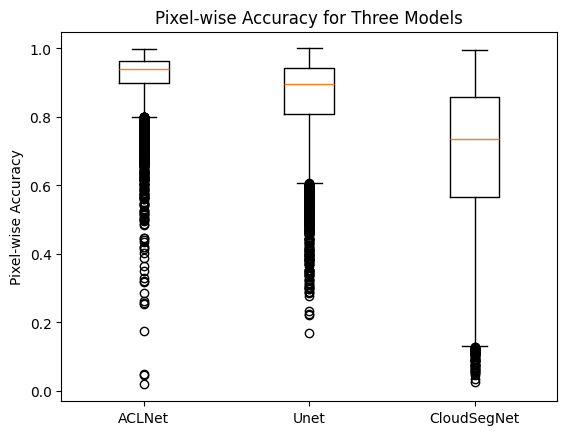

Box (Q1-Q3): [array([0.89834105, 0.89834105, 0.96403598, 0.96403598, 0.89834105]), array([0.80770278, 0.80770278, 0.94198611, 0.94198611, 0.80770278]), array([0.56582222, 0.56582222, 0.85722222, 0.85722222, 0.56582222])]
Median: [array([0.94067081, 0.94067081]), array([0.89663611, 0.89663611]), array([0.73675556, 0.73675556])]
Whiskers: [array([0.89834105, 0.79998553]), array([0.96403598, 0.99986738]), array([0.80770278, 0.60642222]), array([0.94198611, 0.99993333]), array([0.56582222, 0.12984444]), array([0.85722222, 0.99433333])]


In [9]:
acc_boxplot = plt.boxplot(accuracy_dict.values())

plt.xticks([1, 2, 3], accuracy_dict.keys())

plt.ylabel("Pixel-wise Accuracy")
plt.title('Pixel-wise Accuracy for Three Models')
plt.show()

# the key measurements in the boxplot

whiskers = [item.get_ydata() for item in acc_boxplot['whiskers']]
medians = [item.get_ydata() for item in acc_boxplot['medians']]
boxes = [item.get_ydata() for item in acc_boxplot['boxes']]
caps = [item.get_ydata() for item in acc_boxplot['caps']]
fliers = [item.get_ydata() for item in acc_boxplot['fliers']]

# Print extracted values
print("Box (Q1-Q3):", boxes)       # [Q1, Q1, Q3, Q3, Q1]
print("Median:", medians)       # Median line (y-value)
print("Whiskers:", whiskers)       # Lower/upper whisker [min, Q1] and [Q3, max]


In [10]:
def precision_recall_per_image(y_true, y_pred):

    TP = np.sum((y_true == 255) & (y_pred == 255))  # True Positives
    FP = np.sum((y_true == 0) & (y_pred == 255))  # False Positives
    FN = np.sum((y_true == 255) & (y_pred == 0))  # False Negatives
    

    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

In [11]:
netLs = ['ACLNet','Unet','CloudSegNet']

precision_dict = dict()
recall_dict = dict()

for name in netLs:
    
    pred_path = gt_output_file_path + "/"+name 
    precision_dict[name] = []
    recall_dict[name] = []
    
    for f in os.listdir(test_gt):
        
        pred_img = cv2.imread(pred_path + "/" + f)
        gt_img = cv2.imread(test_gt + "/" + f)

   
        size_pred = pred_img.shape[:2]

        gt_img = cv2.resize(gt_img, size_pred)
        
        precision_pixel, recall_pixel = precision_recall_per_image(pred_img,gt_img)
        precision_dict[name].append(precision_pixel)
        recall_dict[name].append(recall_pixel)
    


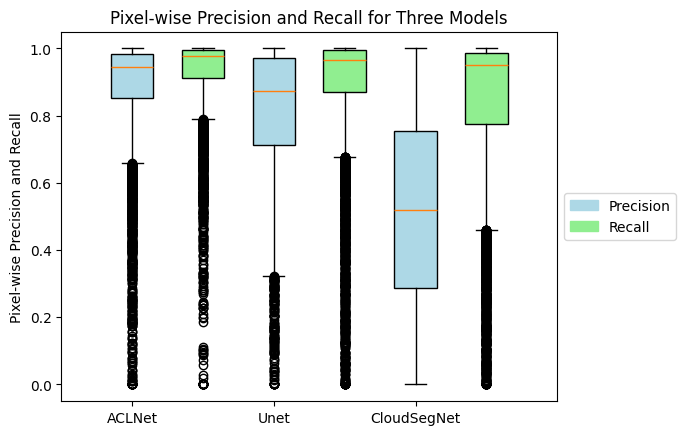

Boxes: [array([0.91352873, 0.91352873, 0.99655145, 0.99655145, 0.91352873,
       0.91352873]), array([0.86899605, 0.86899605, 0.99636073, 0.99636073, 0.86899605,
       0.86899605]), array([0.77561884, 0.77561884, 0.98583217, 0.98583217, 0.77561884,
       0.77561884])]
Whiskers: [array([0.91352873, 0.78934159]), array([0.99655145, 1.        ]), array([0.86899605, 0.67799995]), array([0.99636073, 1.        ]), array([0.77561884, 0.46036073]), array([0.98583217, 1.        ])]
Medians: [array([0.97636007, 0.97636007]), array([0.96611602, 0.96611602]), array([0.95051899, 0.95051899])]
Caps: [array([0.78934159, 0.78934159]), array([1., 1.]), array([0.67799995, 0.67799995]), array([1., 1.]), array([0.46036073, 0.46036073]), array([1., 1.])]
Outliers: [652, 745, 639]


In [17]:

# Define the positions for the boxes
positions1 = [1, 2, 3]        # Positions for the first set of boxes
positions2 = [x + 0.5 for x in positions1]  # Positions for the second set of boxes, shifted right

pre_box = plt.boxplot(precision_dict.values(), positions=positions1, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"))
recall_box = plt.boxplot(recall_dict.values(), positions=positions2, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

plt.xticks([1, 2, 3], precision_dict.keys())

# Create a custom legend to explain the color meaning
colors = {'Precision':'lightblue', 'Recall':'lightgreen'}
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]



plt.legend(handles, colors.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel("Pixel-wise Precision and Recall")
plt.title('Pixel-wise Precision and Recall for Three Models')
plt.show()

# get relative data

boxes = []
whiskers = []
medians = []
caps = []
fliers = []
outliers = []

for box in recall_box['boxes']:
    boxes.append(box.get_path().vertices[:, 1])  # Get y-coordinates of box vertices
    
for whisker in recall_box['whiskers']:
    whiskers.append(whisker.get_ydata())
    
for median in recall_box['medians']:
    medians.append(median.get_ydata())
    
for cap in recall_box['caps']:
    caps.append(cap.get_ydata())
    
for flier in recall_box['fliers']:
    fliers.append(len(flier.get_ydata()))





# Print extracted data
print("Boxes:", boxes)
print("Whiskers:", whiskers)
print("Medians:", medians)
print("Caps:", caps)
print("Outliers:", fliers)




In [10]:
# IoU
def IoU_per_image(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    # Calculate the intersection and union
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    
    iou = intersection / union if union != 0 else 0
    return iou

In [11]:
netLs = ['ACLNet','Unet','CloudSegNet']

iou_dict = dict()

for name in netLs:
    
    pred_path = gt_output_file_path + "/"+name 
    iou_dict[name] = []
    
    for f in os.listdir(test_gt):
        
        pred_img = cv2.imread(pred_path + "/" + f)
        gt_img = cv2.imread(test_gt + "/" + f)

   
        size_pred = pred_img.shape[:2]

        gt_img = cv2.resize(gt_img, size_pred)
        
        iou_img = IoU_per_image(pred_img,gt_img)
        iou_dict[name].append(iou_img)

    


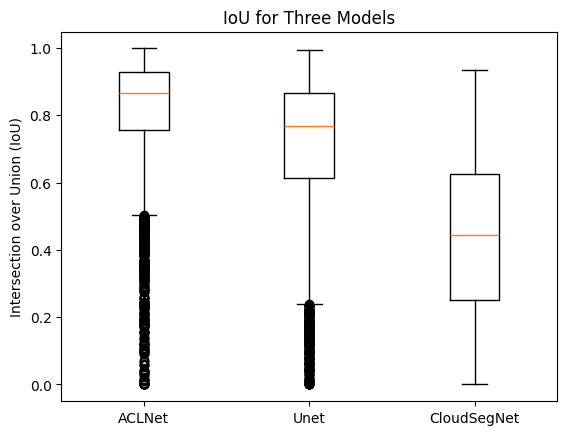

In [12]:
plt.boxplot(iou_dict.values())

plt.xticks([1, 2, 3], iou_dict.keys())

plt.ylabel("Intersection over Union (IoU)")
plt.title('IoU for Three Models')
plt.show()

# Quality Analyze

In [10]:
image_location = "F:\\Cloud segment models\\ACLNet_modify\\data\\imgs/0037_day_aug.png"

scene_image = cv2.imread(image_location)
resized_image = resize(scene_image, (300, 300), order = 0) * 255
resized_image = resized_image.astype("int")
threshold = 0.8

img_map = calculate_map(resized_image,SegNet_Night)

result_Seg = np.zeros(img_map.shape)
result_Seg[img_map > threshold] = 255

1/1 [==============================] - 8s 8s/step


In [14]:
img = Image.open(image_location)
image_np = np.array(img)

# Apply the median filter
filtered_image_np =cv2.medianBlur(image_np, ksize=5)  # Adjust size as needed

# Convert the filtered NumPy array back to a PIL Image
img = Image.fromarray(filtered_image_np)

pred, prob = predict_img(net = net , 
                   full_img = img,
                  scale_factor = 1,
                  out_threshold = 0.6,
                  device = device)


pred_unet = Image.fromarray(np.array(pred*255,dtype = "int8"),"L")

In [17]:
sys.path.append("./src/data/")

from dataloader import *

resize_size = (288, 288)

image = cv2.imread(image_location)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, resize_size)





image_np = np.array(image)

knn_img_150=KNNOutput(image_np)


image_np = np.expand_dims(image_np,axis = 0)
knn_img_150 = np.expand_dims(knn_img_150,axis = 0)
img_150=(image_np,knn_img_150/255)

seg_150 = model.predict(img_150)
mask_150 = seg_150[0].argmax(-1)*255
mask_150 = Image.fromarray(mask_150.astype("uint8"))



# apply threshold and get binary mask
threshold = 0.6
result_acl = np.zeros(seg_150[0][:,:,1].shape)
result_acl[seg_150[0][:,:,1] > threshold] = 255
result_acl = Image.fromarray(result_acl.astype("uint8"), 'L')

D:\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
D:\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


1/1 [==============================] - 2s 2s/step


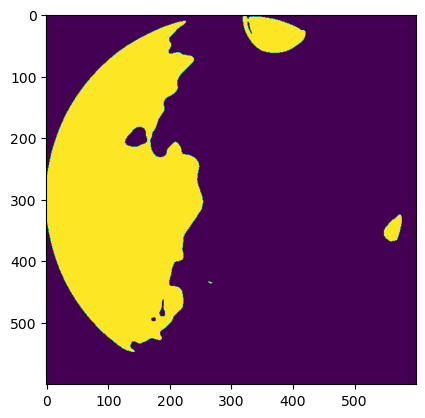

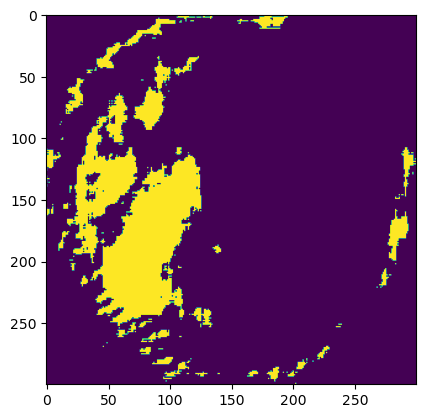

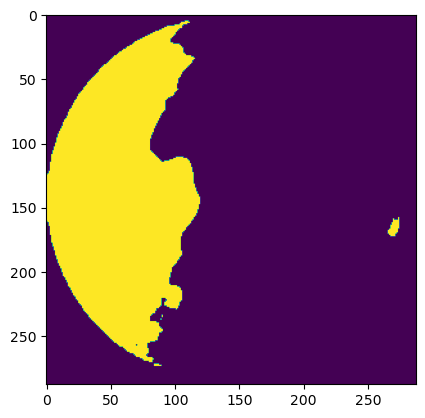

In [18]:
plt.imshow(pred_unet)
plt.show()
plt.imshow(result_Seg)
plt.show()
plt.imshow(result_acl)
plt.show()


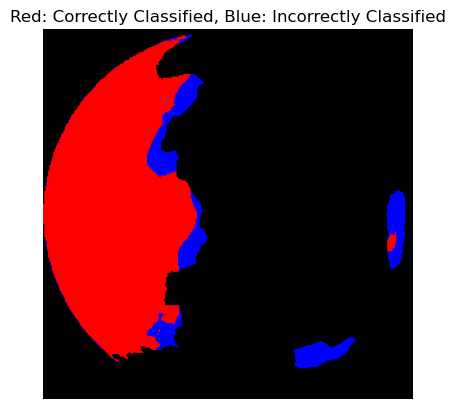

In [19]:

y_true = cv2.imread("F:\\Cloud segment models\\ACLNet_modify\\data\\masks/0037_day_f_aug_GT.png")
resize_size = (288,288)
y_true = y_true[:,:,0]
y_true = cv2.resize(y_true, resize_size)
height, width = y_true.shape
result_image = np.zeros((height, width, 3), dtype=np.uint8)

# Define the class of interest
class_value = 255

result_acl = np.array(result_acl)

# Iterate through each pixel to classify true and false predictions
for i in range(height):
    for j in range(width):
        if y_true[i, j] == class_value:
            if y_true[i, j] == result_acl[i, j]:
                # Correctly classified pixel (red)
                result_image[i, j] = [255, 0, 0]  # Red
            else:
                # Incorrectly classified pixel (blue)
                result_image[i, j] = [0, 0, 255]  # Blue

# Display the result
result_image_acl = result_image.copy()
plt.imshow(result_image)
plt.title("Red: Correctly Classified, Blue: Incorrectly Classified")
plt.axis('off')
plt.show()

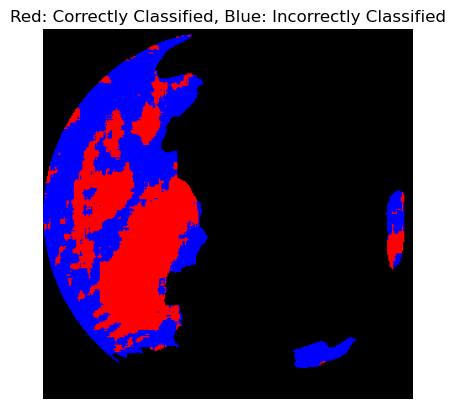

In [20]:
y_true = cv2.imread("F:\\Cloud segment models\\ACLNet_modify\\data\\masks/0037_day_f_aug_GT.png")

resize_size = (300,300)

y_true = y_true[:,:,0]
y_true = cv2.resize(y_true, resize_size)
height, width = y_true.shape
result_image = np.zeros((height, width, 3), dtype=np.uint8)

# Define the class of interest
class_value = 255

result_Seg = np.array(result_Seg)

# Iterate through each pixel to classify true and false predictions
for i in range(height):
    for j in range(width):
        if y_true[i, j] == class_value:
            if y_true[i, j] == result_Seg[i, j]:
                # Correctly classified pixel (red)
                result_image[i, j] = [255, 0, 0]  # Red
            else:
                # Incorrectly classified pixel (blue)
                result_image[i, j] = [0, 0, 255]  # Blue

# Display the result
result_image_seg = result_image.copy()
plt.imshow(result_image)
plt.title("Red: Correctly Classified, Blue: Incorrectly Classified")
plt.axis('off')
plt.show()

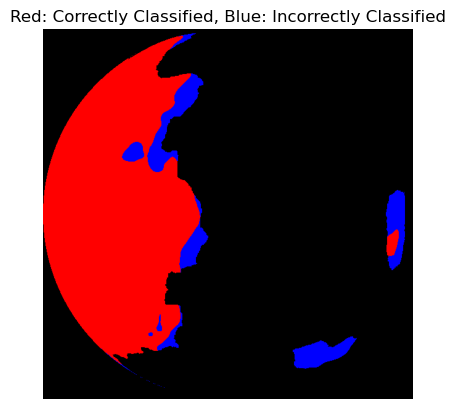

In [21]:
y_true = cv2.imread("F:\\Cloud segment models\\ACLNet_modify\\data\\masks/0037_day_f_aug_GT.png")



y_true = y_true[:,:,0]

height, width = y_true.shape
result_image = np.zeros((height, width, 3), dtype=np.uint8)

# Define the class of interest
class_value = 255

pred_unet = np.array(pred_unet)

# Iterate through each pixel to classify true and false predictions
for i in range(height):
    for j in range(width):
        if y_true[i, j] == class_value:
            if y_true[i, j] == pred_unet[i, j]:
                # Correctly classified pixel (red)
                result_image[i, j] = [255, 0, 0]  # Red
            else:
                # Incorrectly classified pixel (blue)
                result_image[i, j] = [0, 0, 255]  # Blue

# Display the result
result_image_unet = result_image.copy()
plt.imshow(result_image_unet)
plt.title("Red: Correctly Classified, Blue: Incorrectly Classified")
plt.axis('off')
plt.show()

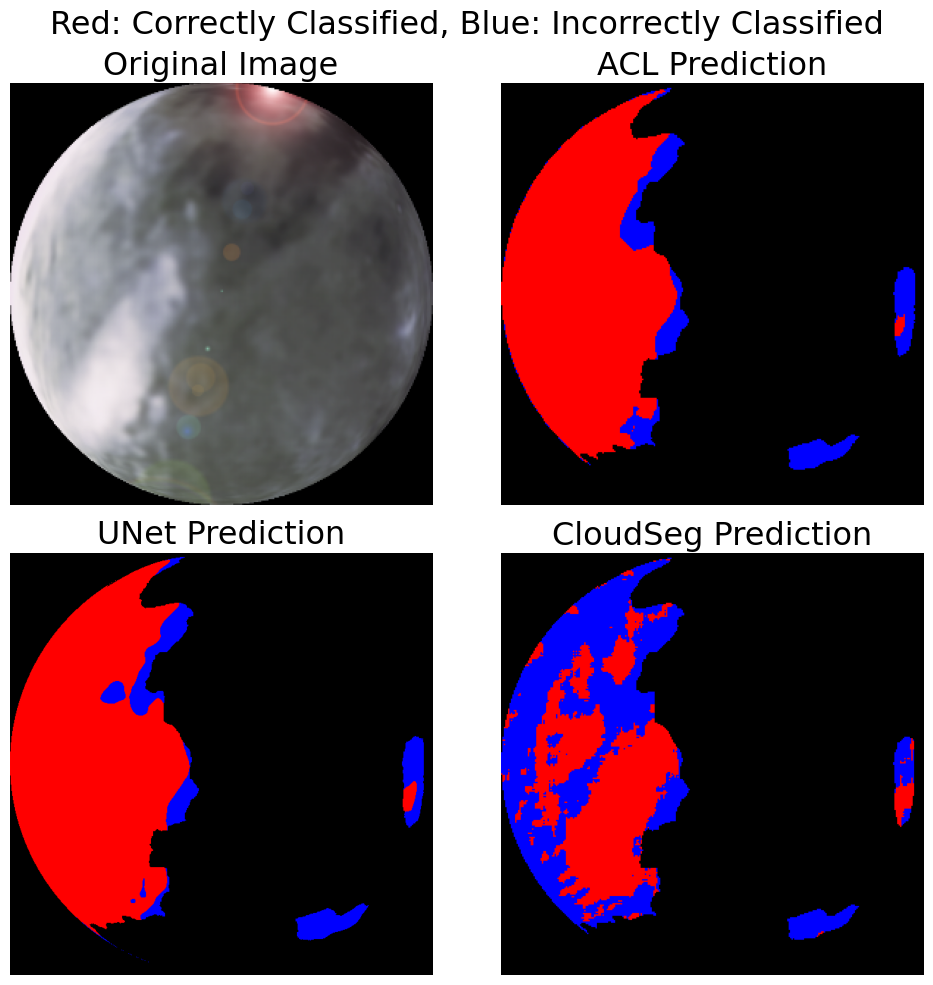

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot original image
axs[0, 0].imshow(image_np[0])
axs[0, 0].set_title('Original Image',fontsize = 23)
axs[0, 0].axis('off')

# Plot ACL prediction
axs[0, 1].imshow(result_image_acl)
axs[0, 1].set_title('ACL Prediction',fontsize = 23)
axs[0, 1].axis('off')

# Plot UNet prediction
axs[1,0].imshow(result_image_unet)
axs[1,0].set_title('UNet Prediction',fontsize = 23)
axs[1,0].axis('off')

# Plot Segmentation prediction
axs[1, 1].imshow(result_image_seg)
axs[1, 1].set_title('CloudSeg Prediction',fontsize = 23)
axs[1, 1].axis('off')


fig.suptitle("Red: Correctly Classified, Blue: Incorrectly Classified", fontsize=23)
plt.tight_layout()
plt.show()